In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path): # Load JSON Data
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print("JSON decode error — file is empty or malformed.")
                return {}
    else:
        return {}  # Return empty dict if file doesn't exist


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

def phase_key_to_short(phase_key):
    """
    Convert 'VO2 (space group 14)' to 'VO2_14'
    """
    if " (space group " in phase_key and phase_key.endswith(")"):
        name, sg = phase_key.split(" (space group ")
        sg = sg.rstrip(")")
        return f"{name} ({sg})"
    return phase_key



In [164]:
# checks that all interpretations have the correct number of phases in the LLM response
json_file_path = "Data/prompt3/interpretations_llm_v2_llama183.json"
json_file = load_json(json_file_path)
def count_errors(json_file):
    missing_interpret = 0
    missing_phase = 0
    correct_interpret = 0
    for sample in json_file:
        flag = False
        for interpret in json_file[sample]:
            if interpret not in ["Synth_Conditions"]:
                if "LLM_interpretation_likelihood_llama" not in json_file[sample][interpret]:
                    print(f"{sample} {interpret} No llama interpretation score")
                    if flag == False:
                        missing_interpret += 1
                    flag = True
                    continue
                gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                phases_llama = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                phases_chat = list(json_file[sample][interpret]["LLM_phases_likelihood"].keys())
                weightfractions = json_file[sample][interpret]["weight_fraction"]
                if len(phases_llama) != len(weightfractions):
                    print(f"llama: {sample} {interpret}")
                    if flag == False:
                        missing_phase +=1
                    flag = True
                    continue
                if len(phases_chat) != len(weightfractions):
                    print(f"chat: {sample} {interpret}")
                    if flag == False:
                        missing_phase += 1
                    flag = True
                    continue 
        if flag == False:
            correct_interpret += 1
    return [missing_phase, missing_interpret, correct_interpret]
def count_errors_noPrint(json_file):
    missing_interpret = 0
    missing_phase = 0
    correct_interpret = 0
    for sample in json_file:
        flag = False
        for interpret in json_file[sample]:
            if interpret not in ["Synth_Conditions"]:
                if "LLM_interpretation_likelihood_llama" not in json_file[sample][interpret]:
                   
                    if flag == False:
                        missing_interpret += 1
                    flag = True
                    continue
                gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                phases_llama = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                phases_chat = list(json_file[sample][interpret]["LLM_phases_likelihood"].keys())
                weightfractions = json_file[sample][interpret]["weight_fraction"]
                if len(phases_llama) != len(weightfractions):
            
                    if flag == False:
                        missing_phase +=1
                    flag = True
                    continue
                if len(phases_chat) != len(weightfractions):
                    
                    if flag == False:
                        missing_phase += 1
                    flag = True
                    continue 
        if flag == False:
            correct_interpret += 1
    return [missing_phase, missing_interpret, correct_interpret]

            
values = count_errors(json_file)
            

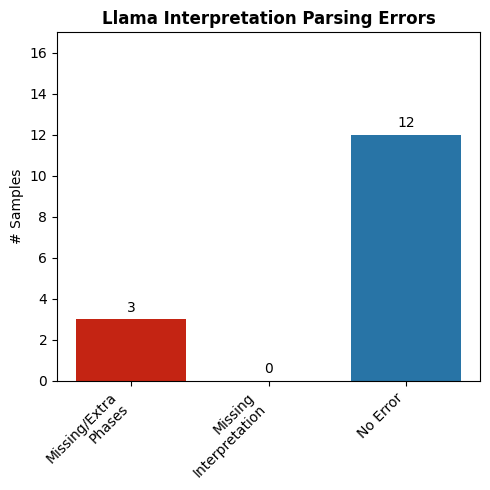

In [110]:
def plot_incorrect_outputs_bar(values, labels=['Missing/Extra\nPhases', 'Missing\nInterpretation', 'No Error'], colors=None, title="Llama Interpretation Parsing Errors", ylabel="# Samples"):
    #Plot the samples with errors and categorize the errors
    if colors is None:
        colors = ["#c42413", '#b03a2e', '#2874a6']
    plt.figure(figsize=(5, 5))
    plt.bar(labels, values, color=colors)
    plt.ylabel(ylabel)
    plt.title(title,fontweight='bold')
    for i, v in enumerate(values):
        plt.text(i, v + max(values)*0.02, f"{v}", ha='center', va='bottom', fontsize=10)
    plt.ylim(top=sum(values)+2)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_incorrect_outputs_bar(values)

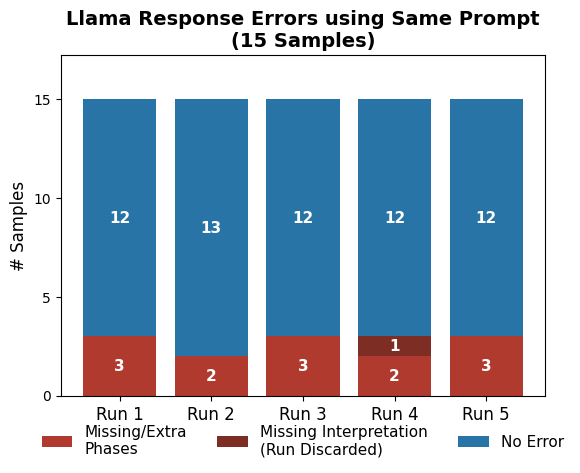

In [162]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_bar_runs(values_list, category_labels=None, run_labels=None, colors=None,
                          ylabel="# Samples", title="Llama Response Errors by Run\n(15 Samples)"):
    n_runs = len(values_list)

    # Default labels and colors
    if category_labels is None:
        category_labels = ['Missing/Extra\nPhases', 'Missing Interpretation\n(Run Discarded)', 'No Error']
    if run_labels is None:
        run_labels = [f"Run {i+1}" for i in range(n_runs)]
    if colors is None:
        colors = ['#b03a2e', '#7d2d24', '#2874a6']

    # Transpose data to group by category
    values_array = np.array(values_list).T  # shape: (n_categories, n_runs)
    indices = np.arange(n_runs)
    bottoms = np.zeros(n_runs)

    # Initialize figure
    plt.figure(figsize=(.8* n_runs + 2, 6))

    # Plot each category as a stacked segment
    for i, (label, color) in enumerate(zip(category_labels, colors)):
        bars = plt.bar(indices, values_array[i], bottom=bottoms, color=color, label=label)

        # Annotate bar segments
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottoms[j] + height / 2
                plt.text(bar.get_x() + bar.get_width() / 2, y_pos, f"{int(height)}",
                         ha='center', va='center', color='white', fontsize=11, fontweight='bold')

        bottoms += values_array[i]

    # Axis formatting
    plt.xticks(indices, run_labels, rotation=0, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.ylim(top=max(bottoms) * 1.15)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.yticks(np.arange(0, 16, 5))

    # Legend at bottom
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22),
               ncol=len(category_labels), fontsize=11, frameon=False)

    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()


json_paths = [
    "Data/prompt3/interpretations_llm_v1_llama1.json",
    "Data/prompt3/interpretations_llm_v1_llama2.json",
    "Data/prompt3/interpretations_llm_v1_llama3.json",
    "Data/prompt3/interpretations_llm_v1_llama4.json",
    "Data/prompt3/interpretations_llm_v1_llama5.json"
]

# Load JSON and count errors
json_files = [load_json(path) for path in json_paths]
list_values = [count_errors_noPrint(j) for j in json_files]

# Plot
plot_stacked_bar_runs(list_values,title="Llama Response Errors using Same Prompt\n(15 Samples)")


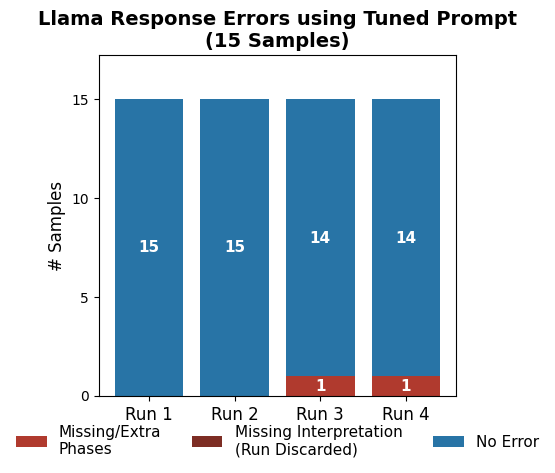

In [163]:
json_file_path1 = "Data/prompt3/interpretations_llm_v2_llama1.json"
json_file_path2 = "Data/prompt3/interpretations_llm_v2_llama2.json"
json_file_path3 = "Data/prompt3/interpretations_llm_v2_llama3.json"
json_file_path4 = "Data/prompt3/interpretations_llm_v2_llama4.json"

json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
json_file3 = load_json(json_file_path3)
json_file4 = load_json(json_file_path4)

list_values = [count_errors_noPrint(json_file1),count_errors_noPrint(json_file2),count_errors_noPrint(json_file3),count_errors_noPrint(json_file4)]
plot_stacked_bar_runs(list_values,title="Llama Response Errors using Tuned Prompt\n(15 Samples)")